## Alex Notebook

##### usefull 

https://machinelearningmastery.com/time-series-seasonality-with-python/ 

https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas

https://plot.ly/python/

https://seaborn.pydata.org/index.html

https://matplotlib.org/gallery/lines_bars_and_markers/categorical_variables.html#sphx-glr-gallery-lines-bars-and-markers-categorical-variables-py

Import modules

In [26]:
# import the modules
import pandas as pd
from influxdb import DataFrameClient, InfluxDBClient
import pytz
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import config

sns.set(style = "ticks")

Define df client for Pandas

In [27]:
client = DataFrameClient(host = config.DB_HOST, port = config.DB_PORT, database = config.DB_DBNAME)

Data exploration

In [96]:
#Set time relative to now for Query (today: 00:00:00)
now = datetime.datetime.today()
past = now - datetime.timedelta(days = config.days_delta)

#Set start and end time
end_time = now.strftime("%Y-%m-%d %H:%M:%S")
start_time = past.strftime("%Y-%m-%d %H:%M:%S")

# NoSQL Query  (to be added: timezone adjusting)
query = "SELECT * FROM \"{}\",\"{}\" WHERE time >= '{}' AND time <= '{}' "\
                        .format(config.stations[0], config.stations[1], start_time, end_time)

df_temp = client.query(query)

mythenquai_1y = pd.DataFrame(df_temp['mythenquai'])
tiefenbrunnen_1y = pd.DataFrame(df_temp['tiefenbrunnen'])

mythenquai_1y.info()
tiefenbrunnen_1y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52498 entries, 2018-12-02 19:10:00+00:00 to 2019-12-02 17:50:00+00:00
Data columns (total 13 columns):
air_temperature            52498 non-null float64
barometric_pressure_qfe    52498 non-null float64
dew_point                  52498 non-null float64
global_radiation           52498 non-null int64
humidity                   52498 non-null int64
precipitation              52498 non-null float64
water_level                4200 non-null float64
water_temperature          52498 non-null float64
wind_direction             52498 non-null int64
wind_force_avg_10min       52498 non-null float64
wind_gust_max_10min        52498 non-null float64
wind_speed_avg_10min       52498 non-null float64
windchill                  52498 non-null float64
dtypes: float64(10), int64(3)
memory usage: 5.6 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52535 entries, 2018-12-02 19:10:00+00:00 to 2019-12-02 17:50:00+00:00
Data columns (total 10 colu

Usefull functions

In [97]:
#usefull functions
def rowindex_as_col(df):
    """add row index(time) to new column. df = dataframe, name_col = new column name"""
    df.index.name = "time"
    df = df.reset_index(inplace = False)
    df = pd.DataFrame(df)
    return df

In [115]:
def add_time_column(df1, df2):
    while True:
        try:
            df1 = rowindex_as_col(df1)
            df2 = rowindex_as_col(df2)
            #show it worked!        
            #df1.info()
            #df2.info()
            
            return df1, df2
            break
        except ValueError:
            return print("The column time already exists!")
            break

In [116]:
def select_timedelta(time_delta_in_days):
    """Make a Select Statement on pass over to new df a certain timedelta from NOW / double_output!: Output1, Output2 = func() /
    example: time_delta_in_days = 10"""
    #Set time relative to now for Query (today: 00:00:00)
    now = datetime.datetime.today()
    past = now - datetime.timedelta(days = time_delta_in_days)

    #Set start and end time
    end_time = now.strftime("%Y-%m-%d %H:%M:%S")
    start_time = past.strftime("%Y-%m-%d %H:%M:%S")

    # NoSQL Query  (to be added: timezone adjusting)
    query = "SELECT * FROM \"{}\",\"{}\" WHERE time >= '{}' AND time <= '{}' "\
                        .format(config.stations[0], config.stations[1], start_time, end_time)
    df_temp = client.query(query)

    # to create pandas df, use only one dicitonary part (mythenquai, tiefenbrunnen)
    df_mythenquai = pd.DataFrame(df_temp['mythenquai'])
    df_tiefenbrunnen = pd.DataFrame(df_temp['tiefenbrunnen'])
    
    df_mythenquai, df_tiefenbrunnen = add_time_column(df_mythenquai, df_tiefenbrunnen)
    
    #show it actually added the time column
    #df_mythenquai.info()
    #df_mythenquai.info()
    
    return df_mythenquai, df_tiefenbrunnen


Change formatting of columns

{'whiskers': [<matplotlib.lines.Line2D at 0x20743c3d400>,
 'caps': [<matplotlib.lines.Line2D at 0x20743c3db00>,
 'boxes': [<matplotlib.lines.Line2D at 0x20743c27f60>],
 'medians': [<matplotlib.lines.Line2D at 0x20743c3de48>],
 'fliers': [<matplotlib.lines.Line2D at 0x20743c4c5c0>],
 'means': []}

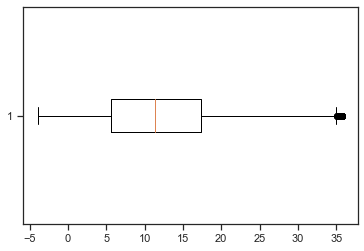

In [10]:
plt.boxplot(mythenquai_1y["air_temperature"], vert = False)

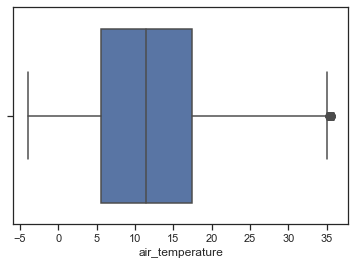

In [11]:
sns.boxplot(x = mythenquai_1y["air_temperature"])

In [88]:
mythenquai_1y_sample = mythenquai_1y[0:10000]
mythenquai_1y_sample_stepped24h = mythenquai_1y[1:50000:144]

In [89]:
time_series_temp = px.line(mythenquai_1y_sample, x = mythenquai_1y_sample["time"], 
                           y = mythenquai_1y_sample["air_temperature"])
time_series_temp.show()

In [113]:
mythenquai_1y_sample["air_temperature"].value_counts(normalize = True, dropna = False)
round(tiefenbrunnen_1y.describe(),1)

,air_temperature,barometric_pressure_qfe,dew_point,humidity,water_temperature,wind_direction,wind_force_avg_10min,wind_gust_max_10min,wind_speed_avg_10min,windchill
count,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0,52535.0
mean,11.9,969.0,7.1,74.7,13.4,133.6,1.0,2.6,1.2,11.2
std,7.7,8.1,6.3,15.4,6.8,113.3,1.1,2.9,1.6,8.1
min,-3.9,940.0,-7.4,19.0,4.7,0.0,0.0,0.0,0.0,-7.2
25%,5.6,964.7,1.9,65.0,6.7,31.0,0.0,0.6,0.0,4.5
50%,11.4,969.2,6.7,77.0,12.1,119.0,1.0,1.8,0.5,10.5
75%,17.4,973.6,12.3,87.0,19.6,215.0,2.0,3.6,1.6,17.2
max,35.8,988.4,23.4,100.0,27.9,360.0,12.4,29.5,12.6,35.9


In [117]:
mythenquai_1d, tiefenbrunnen_1d = select_timedelta(1)

time_series_temp_1d = px.line(mythenquai_1d, x = mythenquai_1d["time"], 
                           y = mythenquai_1d["air_temperature"])
time_series_temp_1d.show()